# Partie 2

## Chargement des données depuis le fichier CSV (non exploité dans le résultat final)

In [3]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/ankitshah009/Task-4-Large-scale-weakly-supervised-sound-event-detection-for-smart-cars/master/groundtruth_weak_label_training_set.csv', 
                   sep='\t', 
                   error_bad_lines=False,
                   names=["file", "start", "end", "label"])
data


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,file,start,end,label
0,2ceUOv8A3FE_20.000_30.000.wav,20.0,30.0,Train horn
1,2hcY8kXQj60_30.000_40.000.wav,30.0,40.0,Train horn
2,2pt7WZBYeeI_30.000_40.000.wav,30.0,40.0,Train horn
3,2wG6EBWr5NQ_30.000_40.000.wav,30.0,40.0,Train horn
4,2wadsgHvSAM_240.000_250.000.wav,240.0,250.0,Train horn
...,...,...,...,...
56126,zjHUFwrJbpc_0.000_10.000.wav,0.0,10.0,Train
56127,zjQsLnmGJn4_60.000_70.000.wav,60.0,70.0,Train
56128,zoeGsPS6ovY_110.000_120.000.wav,110.0,120.0,Train
56129,ztdPIQeG8nw_30.000_40.000.wav,30.0,40.0,Train


## Modèle de prédiction

Le modèle suivant classifie des données sonores en deux classes : cars et trucks.

In [11]:
# -*- coding: utf-8 -*-
"""
Script to learn a model with Scikit-learn.

Created on Mon Oct 24 20:51:47 2022

@author: ValBaron10
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
import pickle
from joblib import dump
from features_functions import compute_features

In [5]:
import wave

def load_wave(filepath, divide_factor=1):

  with wave.open(filepath, "rb") as file:
    audio = file.readframes(file.getnframes())

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

    # Normalise float32 array so that values are between -1.0 and +1.0                                                      
    max_int16 = 2**15
    audio_normalised = audio_as_np_float32 / max_int16

    sections = np.array_split(audio_normalised, divide_factor)
    return sections

In [6]:
labels = ("cars", "trucks")
learningFeatures = False
learningLabels = False
divide_by = 50


for label in labels:

  folder = f"data_part_2/{label}"
  for file in os.scandir(folder): 
    
    if not file.name.endswith(".wav"): continue

    input_signals = load_wave(folder + "/" + file.name, divide_factor=divide_by)

    for input_sig in input_signals:

      # Compute the signal in three domains
      sig_sq = input_sig**2
      sig_t = input_sig / np.sqrt(sig_sq.sum())
      sig_f = np.absolute(np.fft.fft(sig_t))
      sig_c = np.absolute(np.fft.fft(sig_f))

      # Compute the features and store them
      features_list = []
      N_feat, features_list = compute_features(sig_t, sig_f[:sig_t.shape[0]//2], sig_c[:sig_t.shape[0]//2])
      features_vector = np.array(features_list)[np.newaxis,:]

      # Store the obtained features in a np.arrays
      if type(learningFeatures) == bool: learningFeatures = features_vector.copy()
      else: learningFeatures = np.append(learningFeatures, features_vector, axis=0)
    
      if type(learningLabels) == bool: learningLabels = np.array([label])
      else: learningLabels = np.append(learningLabels, [label])

print(f"Samples count: {len(learningFeatures)}")
print("By label:")
unique, counts = np.unique(learningLabels, return_counts=True)
for label, count in zip(unique, counts): print(f"{label}: {count}")
  
# Encode the class names
labelEncoder = preprocessing.LabelEncoder().fit(learningLabels)
learningLabelsStd = labelEncoder.transform(learningLabels)


Samples count: 900
By label:
cars: 450
trucks: 450


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


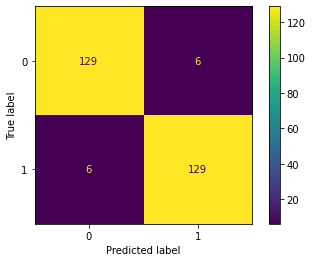

0.9555555555555556


In [ ]:
# Learn the model
model = svm.SVC(C=30, kernel='rbf', class_weight=None, probability=False)
scaler = preprocessing.StandardScaler(with_mean=True).fit(learningFeatures)
learningFeatures_scaled = scaler.transform(learningFeatures)


x_train, x_test, y_train, y_test = train_test_split(
    learningFeatures_scaled, learningLabelsStd, test_size=0.3, shuffle=True
)

model.fit(x_train, y_train)

# Matrix confusion
plot_confusion_matrix(model, x_test, y_test) 
plt.show()


# Export the scaler and model on disk
dump(scaler, "SCALER")
dump(model, "SVM_MODEL")

# Accuracy score
print(accuracy_score(y_test, model.predict(x_test)))

## Recherche des paramètres optimaux pour le modèle

In [ ]:
# Defining parameter range for gridsearch
param_grid = {'C' : [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100],
              'kernel' : ['rbf', 'linear', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(x_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.849 total time=   0.0s
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.825 total time=   0.0s
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.762 total time=   0.0s
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.825 total time=   0.0s
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.833 total time=   0.0s
[CV 1/5] END ................C=1, kernel=linear;, score=0.849 total time=   0.0s
[CV 2/5] END ................C=1, kernel=linear;, score=0.833 total time=   0.0s
[CV 3/5] END ................C=1, kernel=linear;, score=0.754 total time=   0.0s
[CV 4/5] END ................C=1, kernel=linear;, score=0.873 total time=   0.0s
[CV 5/5] END ................C=1, kernel=linear;, score=0.865 total time=   0.0s
[CV 1/5] END ..................C=1, kernel=poly;, score=0.825 total time=   0.0s
[CV 2/5] END ..................C=1, kernel=poly

## Test d'autres modèles

In [7]:
def evaluate_model(model, parameters, x, y):
    
    clf = GridSearchCV(model, parameters)
    scaler = preprocessing.StandardScaler(with_mean=True).fit(x)
    x_scaled = scaler.transform(x)


    x_train, x_test, y_train, y_test = train_test_split(
        x_scaled, y, test_size=0.3, shuffle=True
    )

    clf.fit(x_train, y_train)
    print(clf.best_params_) 
    grid_predictions = clf.predict(x_test) 
   
    # print classification report 
    print(classification_report(y_test, grid_predictions))


## SGD

In [9]:
# Learn the model
model = SGDClassifier()
parameters = {"loss":['hinge', 'modified_huber', 'squared_hinge'],
             "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
evaluate_model(model, parameters, learningFeatures, learningLabelsStd)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_grad

{'alpha': 0.01, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       141
           1       0.82      0.87      0.85       129

    accuracy                           0.85       270
   macro avg       0.85      0.85      0.85       270
weighted avg       0.85      0.85      0.85       270



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## Naive Bayes

In [12]:
# Learn the model
model = GaussianNB()
parameters = {"priors":[None]}
evaluate_model(model, parameters, learningFeatures, learningLabelsStd)



{'priors': None}
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       125
           1       0.74      0.66      0.70       145

    accuracy                           0.70       270
   macro avg       0.70      0.70      0.70       270
weighted avg       0.70      0.70      0.70       270

